# Домашнее задание 1

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями. 

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день.

#### Описание бизнес-процесса, связанного с рядом.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Но ими также могут быть ценные бумаги крупных компаний и деривативы на них. Для банков важно поддерживать некоторый уровень ликвидности, чтобы всегда иметь возможность либо быстро отдать краткосрочные долги. Крупнейшие банковские кризисы во многом состоялись из-за набега вкладчиков, забравших свои деньги, из-за чего банки не могли в моменте обслуживать свои займы. Ликвидные активы можно быстро вложить, если на рынке встретились хорошие условия. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Мы хотим прогнозировать сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 


## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Вам необходимо определить частоту данных, так как от этого будут зависеть параметры модели. Исходя из частоты выберите оффсет [Оффсет](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).Не спешите отвечать на этот вопрос и посмотрите на данные **внимательно**. Сделайте ресэмпл ряда к выбранному оффсету. Если вы всё сделали правильно, то дисперсия ряда должна быть примерно одинаковой на любом участке.

In [8]:
pip install sktime

     |████████████████████████████████| 21.8 MB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 5.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1255]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL
import seaborn as sns

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [1256]:
df = pd.read_csv('data.csv')
df.Date = pd.to_datetime(df.Date)
df = df.set_index(df.Date)
df = df.drop(columns='Date')
df

,Target
Date,
2017-01-09 09:00:00,0.000000
2017-01-09 11:00:00,-0.421841
2017-01-09 13:00:00,0.105555
2017-01-09 15:00:00,0.042276
2017-01-09 17:00:00,0.071416
...,...
2020-09-11 00:00:00,2.180332
2020-09-14 00:00:00,3.307929
2020-09-15 00:00:00,2.644602


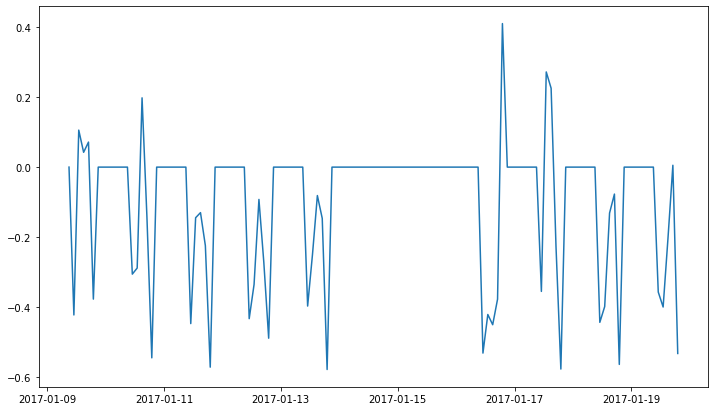

In [1257]:
plt.figure(figsize=(12, 7))

plt.plot(df[:70]);

In [1258]:
# Берем только рабочие дни, потому что в выходные дни таргет нулевой

df_day = df.resample('b').sum()
df_day

,Target
Date,
2017-01-09,-0.579194
2017-01-10,-1.082260
2017-01-11,-1.515704
2017-01-12,-1.618853
2017-01-13,-1.450091
...,...
2020-09-11,2.180332
2020-09-14,3.307929
2020-09-15,2.644602


## 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос. 

Хинт: если построить коррелограммы на приращениях ряда, а не на исходных величинах, то некоторые паттерны видны лучше.


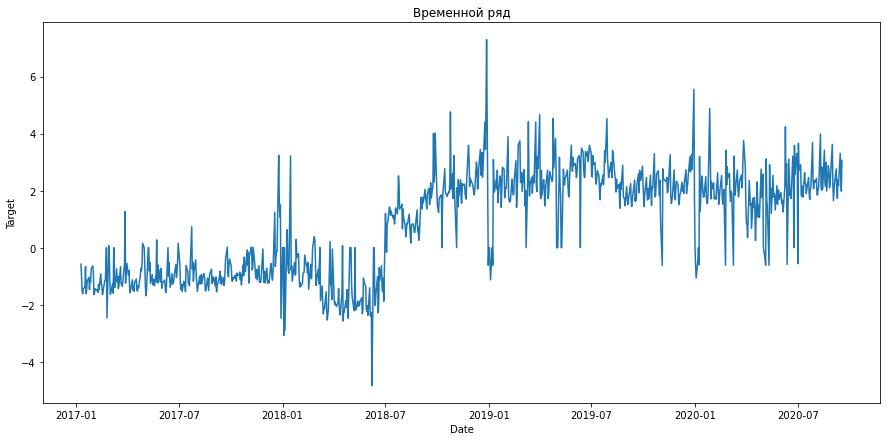

In [1259]:
plt.figure(figsize=(15, 7))

sns.lineplot(x=df_day.index, y=df_day.Target)
plt.title('Временной ряд');

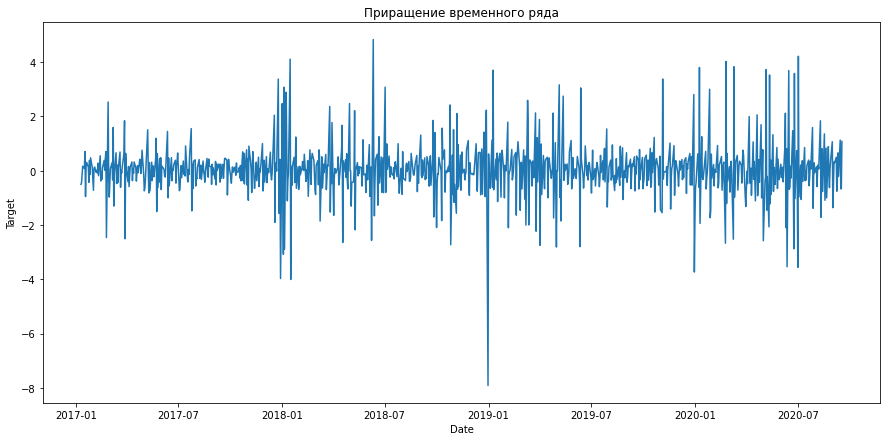

In [1260]:
diff = df_day.diff()[1:]

plt.figure(figsize=(15, 7))

sns.lineplot(x=diff.index, y=diff.Target)
plt.title('Приращение временного ряда');

In [1261]:
diff

,Target
Date,
2017-01-10,-0.503067
2017-01-11,-0.433444
2017-01-12,-0.103149
2017-01-13,0.168763
2017-01-16,0.081969
...,...
2020-09-11,-0.205219
2020-09-14,1.127597
2020-09-15,-0.663328


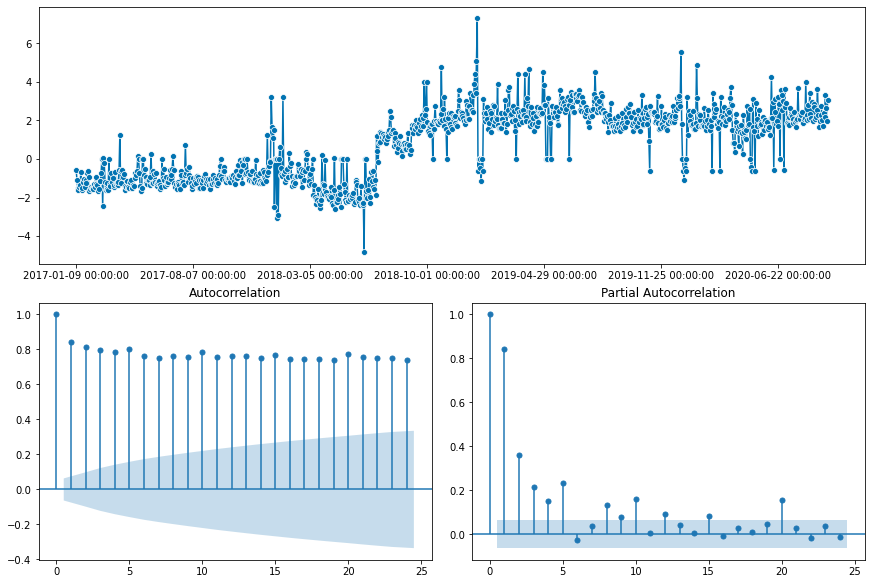

In [1262]:
plot_correlations(df_day);

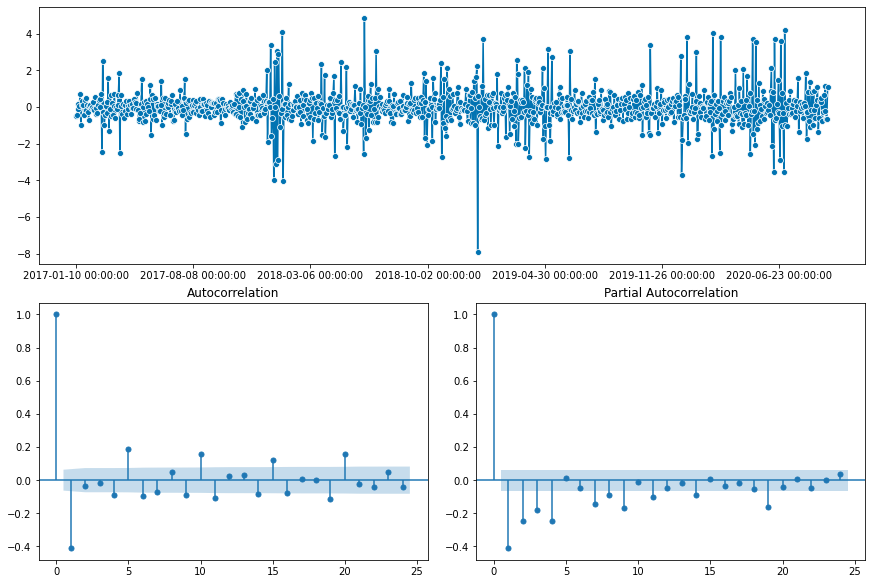

In [1263]:
plot_correlations(diff);

Из первого графика видно, что 18-07 присутствует структурный сдвиг, который меняет матожидание ряда с чуть меньше 0 до значения около 2. Тренд растущий из-за ранееупомянутого сдвига. Сезонность выражается в активном росте target до Нового года и в стремительном его падении сразу же после. Ряд не стационарен, потому что после июля 2018 года мат. ожидание изменяется. Также график с автокорреляцией прироста таргета показывает то, что каждый рабочий день положительно скоррелирован с этим же рабочим днем n-недель назад, то есть, например, понедельник положительно коррелирует с понедельником неделю назад, две недели назад, три недели назад и так далее. 

## 3) Генерация признаков (3 балла)
Во временных рядах очень важно избегать утечек в данных (data leak). Их легко допуситть при неаккуратной генерации признаков. Например, если вы для прогноза $y_t$ будете исплользовать фичу разности $y_t - y_{t-1}$. Будьте осторожны и внимательны.

**Внимание!** При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе). 


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее. Фичи с утечками не засчитываются. Выбор каждой фичи необходимо обосновать. Фичи без обоснования не засчитываются.

1) (0.75 балла) Календарные фичи. Придумайте не менее пяти фичей из календаря. Выбор каждой обоснуйте.
2) (0.15 балла) Структурный сдвиг. В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.
3) (1 балл) Бонус! Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате весьма проблемно, придётся парсить, но это весьма сильная фича. Код парсинга (или описание того, как вы их выкачивали) необходимо приложить, иначе пункт не засчитывается.
4) (0.1 балла) Лаги таргета.  (до 5 разных). Выбор каждого лага обоснуйте.

5) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике. Например. YahooFinance</li>
<li>Спред ставок MosЗrime, все 7 показателей. Ставка MosPrime -- ставка кредитования в рублях на межбанковском рынке России. Спред -- разница между ставками кредита и депозита. У mosprime есть свой сайт.</li>
</ul>

6) Придумайте сами 2 фичи, которые считаете необходимыми (по 0.25 за каждую). Выбор каждой фичи обоснуйте.

Добавленные фичи:

1) Календарные фичи:
* день месяца - разница ликвидность в зависимости от дня 
* номер недели - разница ликвидность в зависимости от недели
* номер месяца - разница ликвидность в зависимости от месяца
* квартал- разница ликвидность в зависимости от квартала
* год - разница ликвидность в зависимости от года
* сезон квартал- разница ликвидность в зависимости от времени года/сезона
* синус на рабочие дни (периодичность 5) - берем периодичность 5, так как была найдена положительная автокорреляция 5-го порядка и далее кратная пяти. 
* косинус на рабочие дни (периодичность 5) - берем периодичность 5, так как была найдена положительная автокорреляция 5-го порядка и далее кратная пяти. 

2) Структурный сдвиг - до 2018-07-15 - 1, после - 0, так как примерно в этот день случился сдвиг (по графику сверху)

3) Бухгалтерские дни - возможно, в бухгалтерские дни банк ведет себя иначе

4) Лаги таргета:
* Все лаги таргета начиная с 1 до 5 - при построении обычного графика автокорреляции была выявлена сильная положительная корреляция с первыми 5 днями, более того, при построении графика для приращений выявилась значительная отрицательная корреляция с 1 днем и положительная корреляция с 5 днем. 

5) Экзогенные фичи:
* Значение ключевой ставки - изменение ключевой ставки может влиять на финансовую систему
* Обменный курс доллара - много чего в нашей жизни зависит от курса доллара
* Спред ставок MosЗrime, все 7 показателей - ставка кредитования может влиять на ликвидность

6) Собственные фичи:
* Индекс МосБиржи инноваций - зависимость ликвидность от рынка инноваций, так как банки сильно связаны с инновациями
* S&P500 - зависимоть ликвидность от ситуации на американском фондовом рынке

In [1264]:
# 1) календарные фичи:

df_day['day'] = df_day.index.day # день месяца
df_day['week'] = df_day.index.week # номер недели
df_day['month'] = df_day.index.month # номер месяца 
df_day['quarter'] = df_day.index.quarter # квартал
df_day['year'] = df_day.index.year # год 
df_day['season'] = df_day.index.month%12 // 3 + 1 # сезон (1 - зима, 2 - весна, 3 - лето, 4 - осень)
t = np.arange(df_day.shape[0])+1
df_day['sin_5'] = np.sin(t * np.pi * 2 / 5) # синус на рабочие дни
df_day['cos_5'] = np.cos(t * np.pi * 2 / 5) # косинус на рабочие дни

/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_60003/3182727513.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_day['week'] = df_day.index.week # номер недели


In [1265]:
# 2) структурный сдвиг:

df_day['shift'] = np.array(df_day.index < '2018-07-15')
df_day['shift'] = df_day['shift'].replace({True:1, False:0})


In [1266]:
# 3) бухгалтерские дни:

df_buh17_1 = pd.read_html('https://glavkniga.ru/situations/k501878')[5]
df_buh17_2 = pd.read_html('https://glavkniga.ru/situations/k501878')[6]
df_buh17_3 = pd.read_html('https://glavkniga.ru/situations/k501878')[7]
df_buh17_4 = pd.read_html('https://glavkniga.ru/situations/k501878')[8]
df_buh17_1 = df_buh17_1.iloc[:,2].apply(lambda x: x.replace('г.', ''))
df_buh17_1 = pd.to_datetime(df_buh17_1.apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh17_2 = df_buh17_2.iloc[:,2].apply(lambda x: x.replace('г.', ''))
df_buh17_2 = pd.to_datetime(df_buh17_2.apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh17_3 = df_buh17_3.iloc[:,2].apply(lambda x: x.replace('г.', ''))
df_buh17_3 = df_buh17_3.apply(lambda x: x.replace('Не позднее ', ''))
df_buh17_3 = df_buh17_3.replace("1017-05-15", "2017-05-15", inplace=True)
df_buh17_3 = pd.to_datetime(df_buh17_3, dayfirst=True)
df_buh17_4 = df_buh17_4.iloc[:,2].apply(lambda x: x.replace('г.', ''))
df_buh17_4 = pd.to_datetime(df_buh17_4.apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh17 = pd.concat((df_buh17_1, df_buh17_2, df_buh17_3, df_buh17_4))

df_day['2017_buchdays'] = [1 if day in df_buh17.values else 0 for day in df_day.index]

In [1267]:
df_buh18_1 = pd.read_html('https://glavkniga.ru/situations/k505289')[5]
df_buh18_2 = pd.read_html('https://glavkniga.ru/situations/k505289')[6]
df_buh18_3 = pd.read_html('https://glavkniga.ru/situations/k505289')[7]
df_buh18_1 = pd.to_datetime(df_buh18_1.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh18_2 = pd.to_datetime(df_buh18_2.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh18_3 = pd.to_datetime(df_buh18_3.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh18 = pd.concat((df_buh18_1, df_buh18_2, df_buh18_3)).reset_index().drop(columns='index')
df_buh18 = df_buh18.rename(columns={0:'2018_buh_days'})
df_buh18

df_day['2018_buchdays'] = [1 if day in df_buh18.values else 0 for day in df_day.index]

In [1268]:
df_buh19_1 = pd.read_html('https://glavkniga.ru/situations/k509370')[5]
df_buh19_2 = pd.read_html('https://glavkniga.ru/situations/k509370')[6]
df_buh19_3 = pd.read_html('https://glavkniga.ru/situations/k509370')[7]
df_buh19_1 = pd.to_datetime(df_buh19_1.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh19_2 = pd.to_datetime(df_buh19_2.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh19_3 = pd.to_datetime(df_buh19_3.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh19 = pd.concat((df_buh19_1, df_buh19_2, df_buh19_3)).reset_index().drop(columns='index')
df_buh19 = df_buh19.rename(columns={0:'2019_buh_days'})
df_buh19

df_day['2019_buchdays'] = [1 if day in df_buh19.values else 0 for day in df_day.index]

In [1269]:
df_buh20_1 = pd.read_html('https://glavkniga.ru/situations/k509621')[5]
df_buh20_2 = pd.read_html('https://glavkniga.ru/situations/k509621')[6]
df_buh20_3 = pd.read_html('https://glavkniga.ru/situations/k509621')[7]
df_buh20_1 = pd.to_datetime(df_buh20_1.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh20_2 = pd.to_datetime(df_buh20_2.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh20_3 = pd.to_datetime(df_buh20_3.iloc[:,2].apply(lambda x: x.replace('Не позднее ', '')), dayfirst=True)
df_buh20 = pd.concat((df_buh20_1, df_buh20_2, df_buh20_3)).reset_index().drop(columns='index')
df_buh20 = df_buh20.rename(columns={0:'2020_buh_days'})
df_buh20

df_day['2020_buchdays'] = [1 if day in df_buh20.values else 0 for day in df_day.index]

In [1270]:
# 4) лаги таргета:

df_day['y_L1'] = df_day['Target'].shift(1)
df_day['y_L2'] = df_day['Target'].shift(2)
df_day['y_L3'] = df_day['Target'].shift(3)
df_day['y_L4'] = df_day['Target'].shift(4)
df_day['y_L5'] = df_day['Target'].shift(5)


In [1271]:
# 5) Экзогенные фичи:

usd_rub = pd.read_csv('USD_RUB.csv') # взяты из https://ru.investing.com/currencies/usd-rub-historical-data
usd_rub['Дата'] = pd.to_datetime(usd_rub['Дата'], dayfirst=True)
usd_rub = usd_rub.rename(columns={'Дата':'Date', 'Цена':'Exchange_rate'})
usd_rub['Exchange_rate'] = usd_rub['Exchange_rate'].apply(lambda x: x.replace(',', '.'))
usd_rub['Exchange_rate'] = usd_rub['Exchange_rate'].astype(float)


df_merged = pd.merge(df_day, usd_rub[['Date', 'Exchange_rate']], left_index=True, right_on='Date', how='left')

In [1272]:
key_rate = pd.read_html('https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=01.01.2017&UniDbQuery.To=13.02.2024')[0]
key_rate = key_rate.rename(columns={'Дата':'Date', 'Ставка':'Key_rate'})

In [1273]:
key_rate['Key_rate'] = key_rate['Key_rate']/100
key_rate['Date'] = pd.to_datetime(key_rate['Date'], dayfirst=True)

In [1274]:
df_merged = pd.merge(df_merged, key_rate, on='Date', how='left')

In [1275]:
import holidays

rus_holidays = holidays.Russia()

In [1276]:
df_merged['Holiday'] = df_merged.Date.apply(lambda x: 1 if x in rus_holidays else 0)

In [1277]:
df_merged = df_merged.set_index('Date')

In [1278]:
mosprime = pd.read_excel('mosprime.xlsx', skiprows=1)
# взято из: https://mosprime.com/archive?date_from=2017-01-01&date_to=2021-01-01&contributor
mosprime['Дата ставки'] = pd.to_datetime(mosprime['Дата ставки'], dayfirst=True)
mosprime = mosprime.set_index('Дата ставки')
mosprime = mosprime[1:]
mosprime = mosprime.rename(columns={'ON':'mosprime_1_day', 
                                  '1W':'mosprime_1_week', 
                                  '2W':'mosprime_2_week', 
                                  '1M':'mosprime_1_month', 
                                  '2M':'mosprime_2_month', 
                                  '3M':'mosprime_3_month', 
                                  '6M':'mosprime_6_month'
                                 })


mosprime.astype(str)
for col in mosprime.columns:
    mosprime[col] = mosprime[col].astype(str, copy=True)
    mosprime[col] = mosprime[col].apply(lambda x: x.replace(',', '.'))
    mosprime[col] = mosprime[col].apply(lambda x: x.replace('–', '0'))
    mosprime[col] = mosprime[col].apply(lambda x: x.replace('-', '0'))
    mosprime[col] = mosprime[col].astype(float)

In [1280]:
df_merged = pd.merge(df_merged, mosprime, left_index=True, right_index=True, how='left')

In [1281]:
# 6) Собственные фичи

In [1282]:
moexinn = pd.read_xml('https://iss.moex.com/issrpc/marketdata/indices/archive/archive_indices_2017-01-01-2024-02-14.xml?date_from=2017-01-01&date_till=2024-02-14&indices=22264438&lang=ru&iss.delimiter=,&iss.dp=comma')
moexinn.drop(index=0, inplace=True)
moexinn = moexinn[['TRADEDATE', 'OPEN']]
moexinn['TRADEDATE'] = pd.to_datetime(moexinn['TRADEDATE'])
moexinn = moexinn.set_index('TRADEDATE')
moexinn = moexinn.rename(columns={'OPEN':'MOEXINN_OPEN'})
moexinn

,MOEXINN_OPEN
TRADEDATE,
2017-01-03,386.92
2017-01-04,386.29
2017-01-05,384.94
2017-01-06,383.05
2017-01-09,381.03
...,...
2024-02-08,707.26
2024-02-09,693.52
2024-02-12,682.47


In [1283]:
SandP500 = pd.read_csv('S&P500.csv')
SandP500 = SandP500[['Дата', 'Цена']]
SandP500['Дата'] = pd.to_datetime(SandP500['Дата'], dayfirst=True)
SandP500 = SandP500.set_index('Дата')
SandP500 = SandP500.rename(columns={'Цена':'S&P500'})
SandP500['S&P500'] = SandP500['S&P500'].apply(lambda x: x.replace('.', ''))
SandP500['S&P500'] = SandP500['S&P500'].apply(lambda x: x.replace(',', '.'))
SandP500['S&P500'] = SandP500['S&P500'].astype(float)
SandP500

,S&P500
Дата,
2024-02-14,4970.42
2024-02-13,4953.17
2024-02-12,5021.84
2024-02-09,5026.61
2024-02-08,4997.91
...,...
2017-01-09,2268.90
2017-01-06,2276.98
2017-01-05,2269.00


In [1284]:
df_merged = pd.merge(df_merged, moexinn, left_index=True, right_index=True, how='left')
df_merged

,Target,day,week,month,quarter,year,season,sin_5,cos_5,shift,...,Key_rate,Holiday,mosprime_1_day,mosprime_1_week,mosprime_2_week,mosprime_1_month,mosprime_2_month,mosprime_3_month,mosprime_6_month,MOEXINN_OPEN
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,-0.579194,9,2,1,1,2017,1,9.510565e-01,0.309017,1,...,10.00,0,10.46,10.44,10.47,10.52,10.58,10.58,10.58,381.03
2017-01-10,-1.082260,10,2,1,1,2017,1,5.877853e-01,-0.809017,1,...,10.00,0,10.21,10.40,10.48,10.53,10.59,10.59,10.59,386.49
2017-01-11,-1.515704,11,2,1,1,2017,1,-5.877853e-01,-0.809017,1,...,10.00,0,10.23,10.40,10.48,10.53,10.59,10.59,10.59,384.96
2017-01-12,-1.618853,12,2,1,1,2017,1,-9.510565e-01,0.309017,1,...,10.00,0,10.23,10.42,10.48,10.53,10.59,10.59,10.59,381.45
2017-01-13,-1.450091,13,2,1,1,2017,1,-2.449294e-16,1.000000,1,...,10.00,0,10.27,10.40,10.45,10.51,10.58,10.59,10.59,379.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,2.180332,11,37,9,3,2020,4,-4.702644e-14,1.000000,0,...,4.25,0,4.36,4.45,4.46,4.50,4.56,4.65,4.67,389.75
2020-09-14,3.307929,14,38,9,3,2020,4,9.510565e-01,0.309017,0,...,4.25,0,4.36,4.44,4.44,4.49,4.55,4.63,4.66,395.52
2020-09-15,2.644602,15,38,9,3,2020,4,5.877853e-01,-0.809017,0,...,4.25,0,4.37,4.45,4.45,4.50,4.55,4.63,4.66,393.76


In [1285]:
df_merged = pd.merge(df_merged, SandP500, left_index=True, right_index=True, how='left')
df_merged

,Target,day,week,month,quarter,year,season,sin_5,cos_5,shift,...,Holiday,mosprime_1_day,mosprime_1_week,mosprime_2_week,mosprime_1_month,mosprime_2_month,mosprime_3_month,mosprime_6_month,MOEXINN_OPEN,S&P500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,-0.579194,9,2,1,1,2017,1,9.510565e-01,0.309017,1,...,0,10.46,10.44,10.47,10.52,10.58,10.58,10.58,381.03,2268.90
2017-01-10,-1.082260,10,2,1,1,2017,1,5.877853e-01,-0.809017,1,...,0,10.21,10.40,10.48,10.53,10.59,10.59,10.59,386.49,2268.90
2017-01-11,-1.515704,11,2,1,1,2017,1,-5.877853e-01,-0.809017,1,...,0,10.23,10.40,10.48,10.53,10.59,10.59,10.59,384.96,2275.32
2017-01-12,-1.618853,12,2,1,1,2017,1,-9.510565e-01,0.309017,1,...,0,10.23,10.42,10.48,10.53,10.59,10.59,10.59,381.45,2270.44
2017-01-13,-1.450091,13,2,1,1,2017,1,-2.449294e-16,1.000000,1,...,0,10.27,10.40,10.45,10.51,10.58,10.59,10.59,379.86,2274.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,2.180332,11,37,9,3,2020,4,-4.702644e-14,1.000000,0,...,0,4.36,4.45,4.46,4.50,4.56,4.65,4.67,389.75,3340.97
2020-09-14,3.307929,14,38,9,3,2020,4,9.510565e-01,0.309017,0,...,0,4.36,4.44,4.44,4.49,4.55,4.63,4.66,395.52,3383.54
2020-09-15,2.644602,15,38,9,3,2020,4,5.877853e-01,-0.809017,0,...,0,4.37,4.45,4.45,4.50,4.55,4.63,4.66,393.76,3401.20


In [1286]:
df_merged = df_merged.iloc[5:]
df_merged = df_merged.fillna(method='backfill') 
# заполняем прошлыми значениями, потому что преполагается, что с прошлой даты ничего не поменялось
df_merged

,Target,day,week,month,quarter,year,season,sin_5,cos_5,shift,...,Holiday,mosprime_1_day,mosprime_1_week,mosprime_2_week,mosprime_1_month,mosprime_2_month,mosprime_3_month,mosprime_6_month,MOEXINN_OPEN,S&P500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,-1.368122,16,3,1,1,2017,1,9.510565e-01,0.309017,1,...,0,10.32,10.42,10.44,10.47,10.51,10.52,10.52,381.25,2267.89
2017-01-17,-0.660347,17,3,1,1,2017,1,5.877853e-01,-0.809017,1,...,0,10.37,10.42,10.44,10.46,10.49,10.50,10.50,381.58,2267.89
2017-01-18,-1.611816,18,3,1,1,2017,1,-5.877853e-01,-0.809017,1,...,0,10.38,10.42,10.44,10.46,10.49,10.50,10.50,381.66,2271.89
2017-01-19,-1.484388,19,3,1,1,2017,1,-9.510565e-01,0.309017,1,...,0,10.43,10.48,10.48,10.46,10.49,10.50,10.50,381.17,2263.69
2017-01-20,-1.176678,20,3,1,1,2017,1,-4.898587e-16,1.000000,1,...,0,10.30,10.46,10.49,10.46,10.49,10.50,10.50,404.92,2271.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-11,2.180332,11,37,9,3,2020,4,-4.702644e-14,1.000000,0,...,0,4.36,4.45,4.46,4.50,4.56,4.65,4.67,389.75,3340.97
2020-09-14,3.307929,14,38,9,3,2020,4,9.510565e-01,0.309017,0,...,0,4.36,4.44,4.44,4.49,4.55,4.63,4.66,395.52,3383.54
2020-09-15,2.644602,15,38,9,3,2020,4,5.877853e-01,-0.809017,0,...,0,4.37,4.45,4.45,4.50,4.55,4.63,4.66,393.76,3401.20


## 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

#### 4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [1287]:
from sklearn.model_selection import train_test_split

y = df_merged['Target']
X = df_merged.drop(columns='Target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [1288]:
def plot_hists(X, names):
    plt.figure(figsize=(10 * 5, 10 * 4))
    for i in range(X.shape[1]):
        plt.subplot(8, 4, i + 1)
        plt.grid()
        plt.hist(X[names[i]], alpha=0.5, color="C4")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout();

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

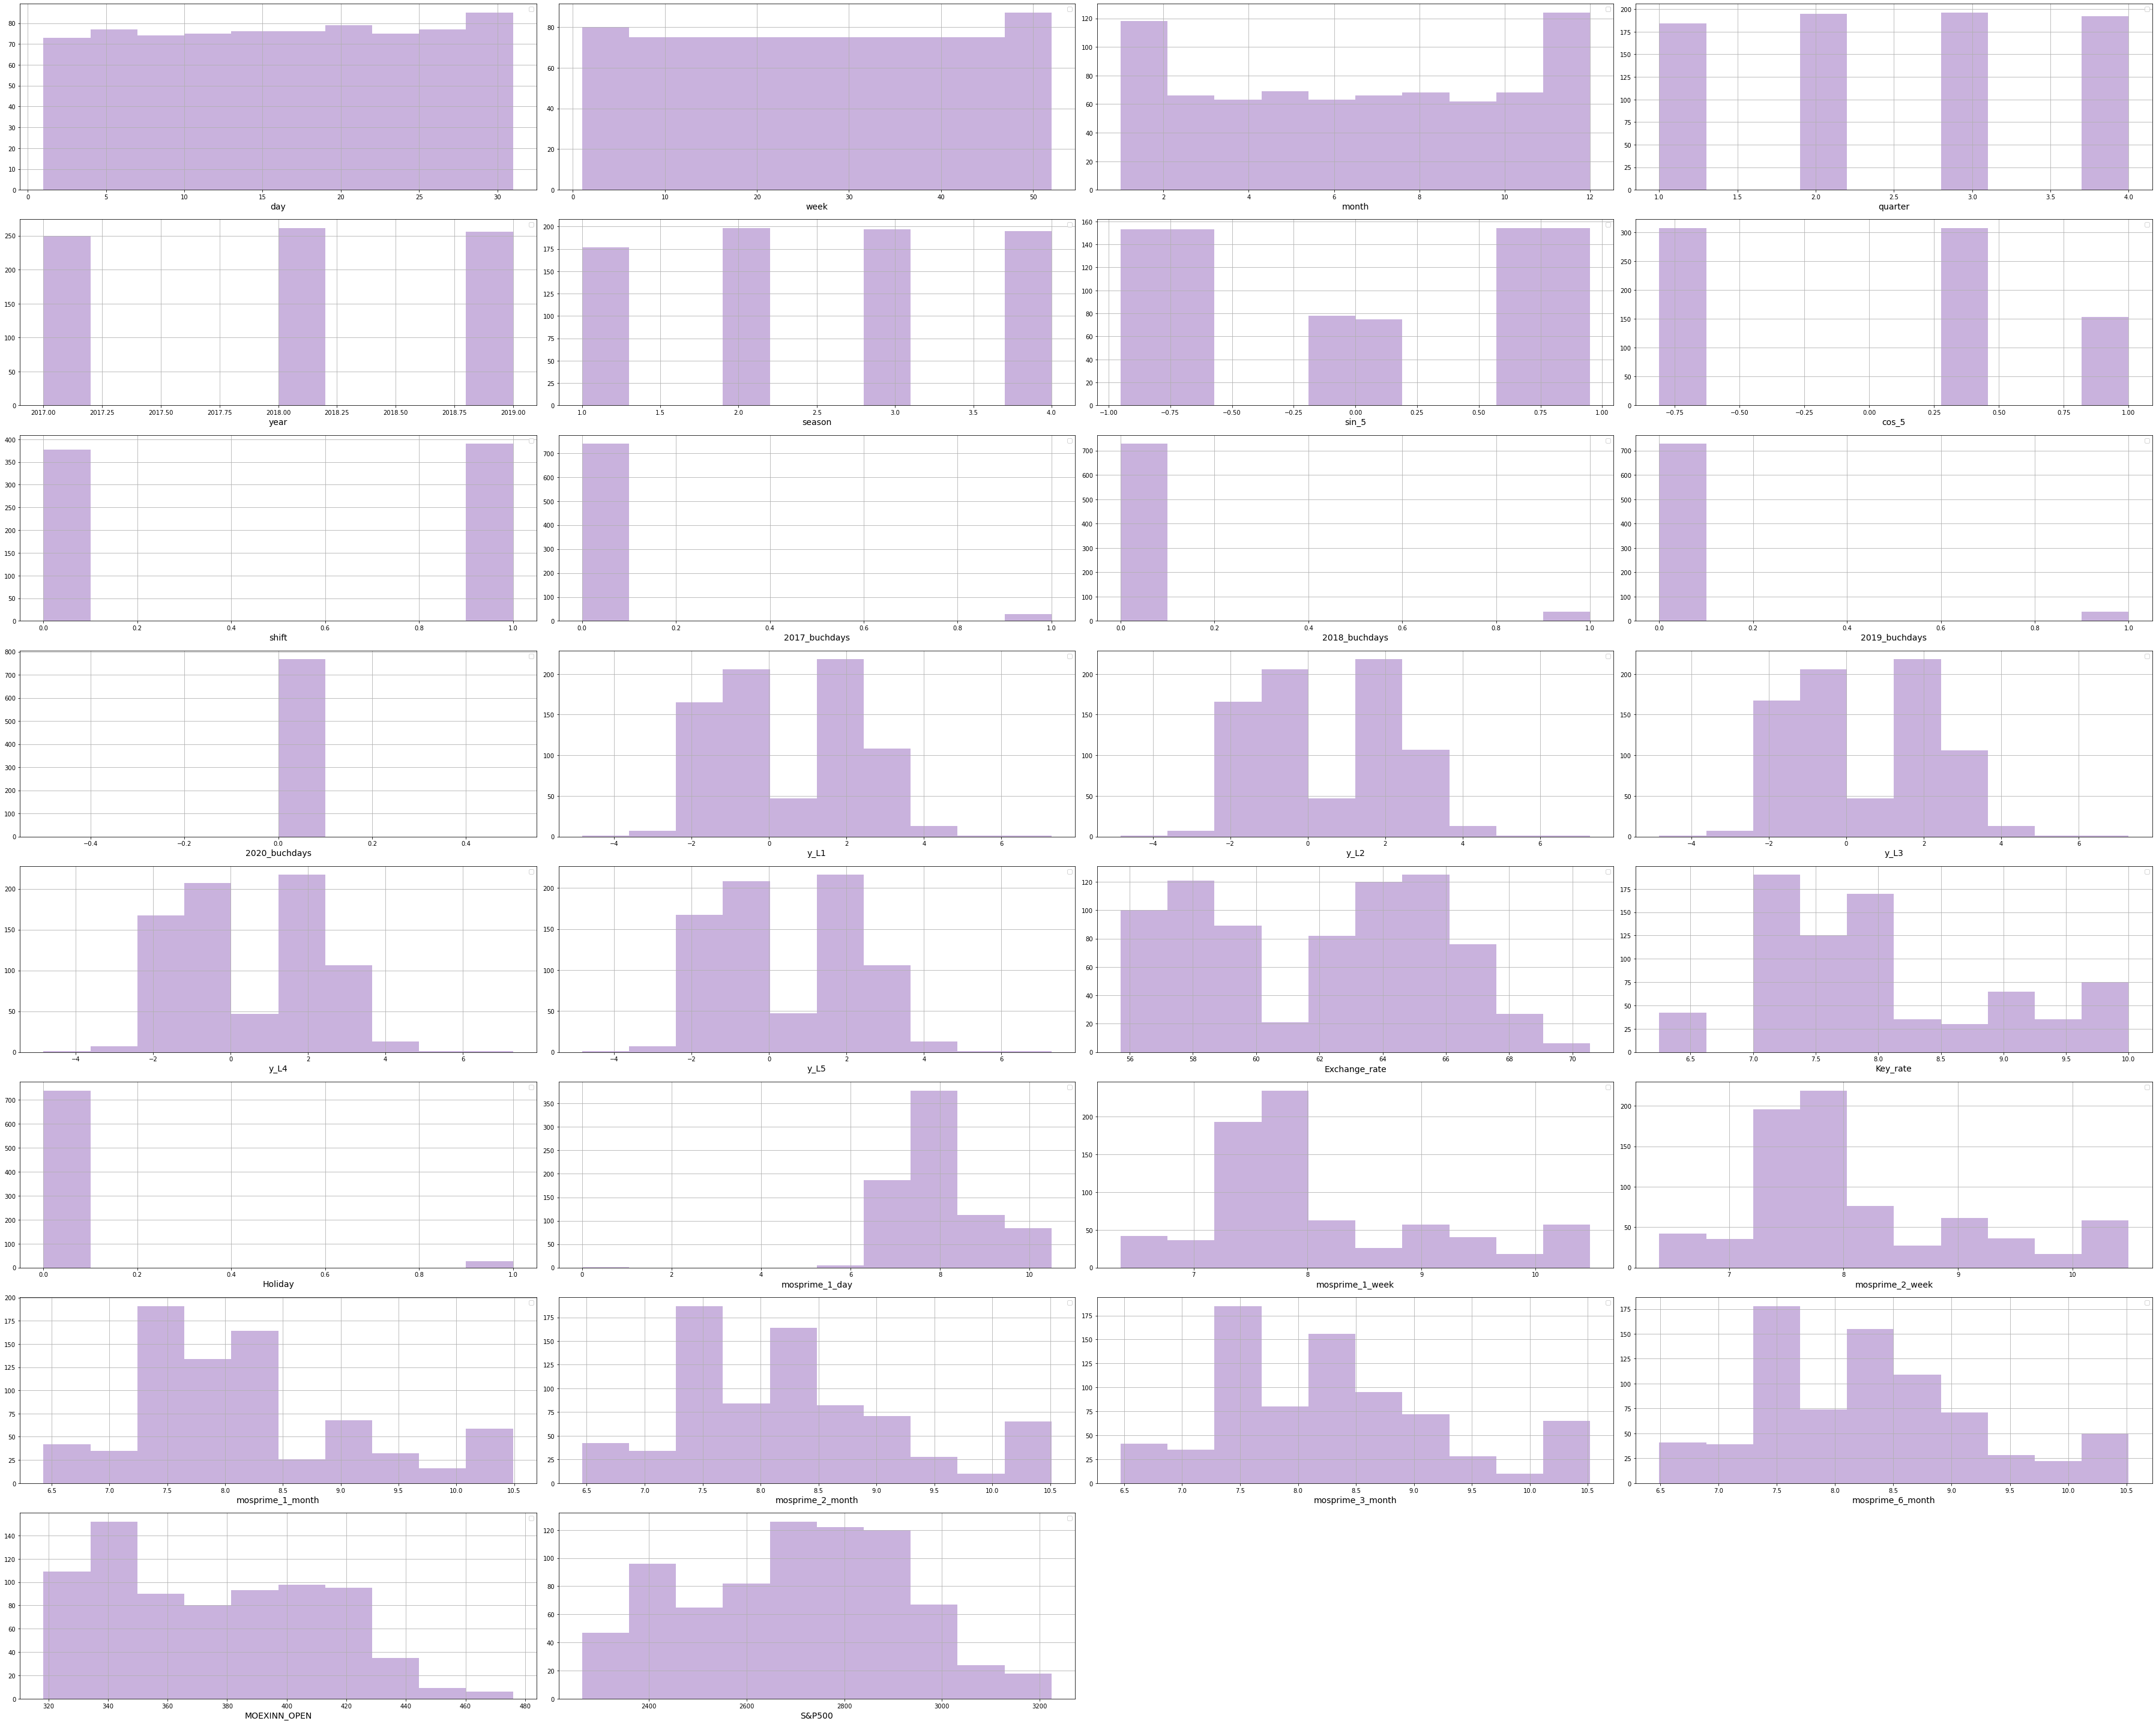

In [1289]:
plot_hists(X_train, X_train.columns);

Будем использовать градиентный бустинг, поэтому данные можно не нормировать.

#### 4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте WAPE. 

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

In [855]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor(random_state=0)

parameters = {'learning_rate' : [0.1, 0.3, 0.5, 0.7, 1], 
              'n_estimators':[100, 200, 300],
              'min_samples_split':[2, 4, 8],
              'min_samples_leaf':[1, 3, 5],
              'max_depth':[2, 3, 5]}

clf = GridSearchCV(gbr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [2, 3, 5], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 200, 300]})

In [1290]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

In [1291]:
# данные 

gbr_best = GradientBoostingRegressor(random_state=0, **clf.best_params_)

gbr_best.fit(X_train, y_train)
y_pred = pd.Series(gbr_best.predict(X_test), index=y_test.index)

def wape(y_F, y_A):
    return np.sum(np.abs(y_A - y_F)) / np.sum(np.abs(y_A))

wape(y_pred, y_test)

0.2716455032705869

#### 4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна. Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [1292]:
naive = pd.Series(np.full(shape=y_test.shape[0], fill_value=y_train[-1]), index=y_test.index)
wape(naive, y_test)

0.4358131824627795

#### 4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

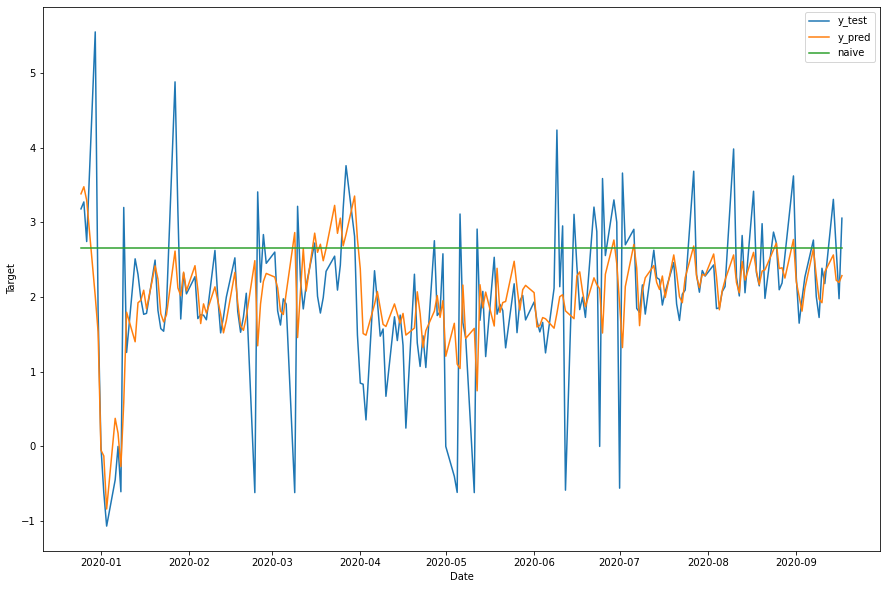

In [1293]:
import seaborn as sns

plt.figure(figsize=(15, 10))
sns.lineplot(x=y_test.index, y=y_test.values)
sns.lineplot(x=y_pred.index, y=y_pred.values)
sns.lineplot(x=naive.index, y=naive.values)
plt.legend(['y_test', 'y_pred', 'naive'])
plt.xlabel('Date')
plt.ylabel('Target');

## 5) Многошаговое прогнозирование


Описание всех необходимых стратегий есть в [Конспекте](https://github.com/Pyatachokk/hse_ts_course/blob/master/2024-spring/seminars/sem_02_tables.pdf)

#### 5.1) Повтор препроцессинга (0 баллов)

Вернёмся к полному датасету. Повторите разбиение на трейн и тест. Возьмём в качестве теста последние 50 наблюдений. Соответственно, горизонт прогнозирования будет равен 50. Для упрощения задачи уберём все экзогенные переменные из датасета, которые нужно прогнозировать. Оставим только лаги таргета, календарные фичи и придуманные вами фичи если их не надо прогнозировать. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

In [1295]:
selected_features = ['day', 'week', 'month', 'year', 'season', 'sin_5', 'cos_5', 'shift', 'Holiday', 
                     '2017_buchdays', '2018_buchdays', '2019_buchdays', '2020_buchdays', 
                     'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5']

clean_X = X[selected_features]

test_size = 50/clean_X.shape[0]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(clean_X, y, test_size=test_size, random_state=42, shuffle=False)

In [1296]:
X_train_1, X_test_1, y_train_1, y_test_1 = X_train_1.to_numpy(), X_test_1.to_numpy(), y_train_1.to_numpy(), y_test_1.to_numpy()

#### 5.2) Рекурсивная стратегия (2 балла)

Внимание! Внимание! Запрещается пользоваться готовыми функциями. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1297]:
from sklearn.linear_model import LinearRegression

class Recursive:
    def __init__(self, model):
        self.model = model
        
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
    def predict(self, X_test):
        predictions = []
        window = X_test[0,-5:]
        for i in range(X_test.shape[0]):
            data = np.concatenate((X_test[i,:-5], window), axis=0)[np.newaxis,]
            pred = self.model.predict(data)
            predictions.append(float(pred))
            window = np.insert(window, 0, pred)[:-1]
        return predictions

In [1298]:
rec = Recursive(GradientBoostingRegressor(random_state=2, **clf.best_params_))
rec.fit(X_train_1, y_train_1)

In [1299]:
preds_rec = rec.predict(X_test_1)

In [1300]:
wape(preds_rec, y_test_1)

0.14477929472017864

#### 5.3) Прямая стратегия (1 балла)

Внимание! Запрещается пользоваться готовыми функциями. Прямую стратегию необходимо написать вручную!

Реализуйте прямое прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1301]:
class Direct:
    def __init__(self, steps):
#         self.model = model
        self.models = []
        self.steps = steps
        
    def fit(self, X_train, y_train):
        for step in range(self.steps):
            model = GradientBoostingRegressor(random_state=0, **clf.best_params_)
            m = model.fit(X_train[:X_train.shape[0]-step,], y_train[:y_train.shape[0]-step])
            self.models.append(m)
        
    def predict(self, X_test):
        preds = []
        for step in range(self.steps):
            pred = self.models[step].predict(X_test[step,][np.newaxis,])
            preds.append(float(pred))
        return preds

In [1302]:
direct = Direct(X_test_1.shape[0])
direct.fit(X_train_1, y_train_1)

In [1303]:
preds_dir = direct.predict(X_test_1)

In [1304]:
wape(preds_dir, y_test_1)

0.13581179681668384

#### 5.4) Стратегия DirRec (1.5 балла)

Внимание! Запрещается пользоваться готовыми функциями. Стратегию необходимо написать вручную!

Реализуйте смешанное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1305]:
class DirRec:
    def __init__(self, steps):
        self.models = []
        self.steps = steps
        
    def fit(self, X_train, y_train):
        for step in range(self.steps):
            model = GradientBoostingRegressor(random_state=0, **clf.best_params_)
            if step == 0:
                m = model.fit(X_train[:X_train.shape[0]-step,], y_train[:y_train.shape[0]-step])
                self.models.append(m)
            else:
                y_train_copy = np.roll(y_train, 5+step).reshape(-1,1)
                X_train = np.concatenate((X_train, y_train_copy), axis=1)
                m = model.fit(X_train[:X_train.shape[0]-step,][5+step:,], 
                                   y_train[:y_train.shape[0]-step][5+step:])
                self.models.append(m)
        
    def predict(self, X_test):
        preds = []
        window = X_test[0,-5:]
        for step in range(self.steps):
            data = np.concatenate((X_test[step,:-5], window), axis=0)[np.newaxis,]
            pred = self.models[step].predict(data)
            preds.append(float(pred))
            window = np.insert(window, 0, pred)
            
        return preds

In [1306]:
dirrec = DirRec(X_test_1.shape[0])
dirrec.fit(X_train_1, y_train_1)

In [1307]:
preds_dirrec = dirrec.predict(X_test_1)

In [1308]:
wape(y_test_1, preds_dirrec)

0.13841881119162597

#### 5.5) Результаты (0.5 балла)

Визуализируйте прогнозы стратегий и тестовые данные на одном графике. Подсчитайте WAPE прогнозов. Какая оказалась лучше? Как вы думаете, почему?

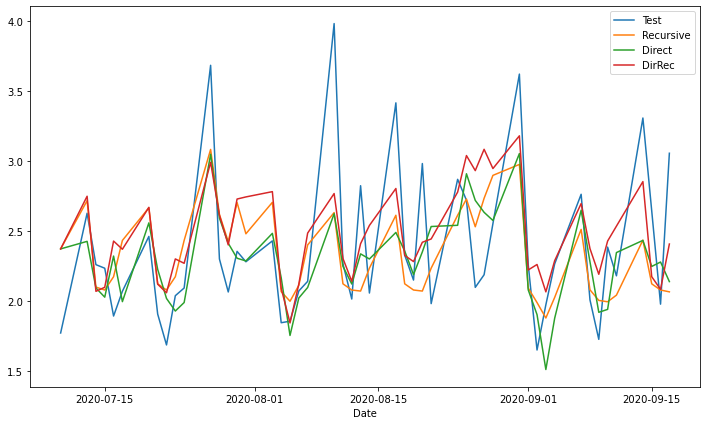

In [1309]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.lineplot(x=y[-50:].index, y=y_test_1)
sns.lineplot(x=y[-50:].index, y=preds_rec)
sns.lineplot(x=y[-50:].index, y=preds_dir)
sns.lineplot(x=y[-50:].index, y=preds_dirrec)
plt.legend(['Test', 'Recursive', 'Direct', 'DirRec']);

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/eKQTEKbYKD9YripL8